In [18]:
import csv
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from multiprocessing import Pool, shared_memory
import multiprocessing as mp

In [19]:
def read_microdata(filename):
    # Open the file in read mode
    with open(filename, mode='r', newline='') as file:
        reader = csv.reader(file)
        first_line = next(reader)
        headers = first_line[1:]
        data_array = np.empty((0, len(headers)), dtype=float)
        micro_data_ids =[]
        # Iterate through each row in the CSV file
        for row in reader:
            # Process each row
            micro_data_ids.append(row[0])
            data_array = np.append(data_array, [np.array(row[1:], dtype=float)], axis=0)
    return {
        'headers':headers,
        'micro_data_ids':micro_data_ids,
        'data_array':data_array
    }

In [20]:
def read_constraints(filename):
    # Open the file in read mode
    with open(filename, mode='r', newline='') as file:
        reader = csv.reader(file)
        first_line = next(reader)
        headers = first_line[2:]
        data_array = np.empty((0, len(headers)), dtype=float)
        geo_data_ids =[]
        population_totals=[]
        # Iterate through each row in the CSV file
        for row in reader:
            # Process each row
            geo_data_ids.append(row[0])
            population_totals.append(row[1])
            data_array = np.append(data_array, [np.array(row[2:], dtype=float)], axis=0)
    return {
        'headers':headers,
        'geo_data_ids':geo_data_ids,
        'population_totals':population_totals,
        'data_array':data_array
    }

In [21]:
micro_data = read_microdata('../data/Sandbox/microdata_encoded.csv')
constraint_data = read_constraints('../data/Sandbox/constraint_targets.csv')


In [22]:
micro_data['headers'] == constraint_data['headers']


True

In [23]:
class ParallelSimulatedAnnealing:
    _shared_microdata = None  # Class-level shared data reference
    
    @classmethod
    def initialize_shared_microdata(cls, micro_data_array):
        """Initialize shared memory once for all instances"""
        if cls._shared_microdata is None:
            # Create shared memory block
            shm = shared_memory.SharedMemory(create=True, size=micro_data_array.nbytes)
            
            # Create numpy array backed by shared memory
            shared_array = np.ndarray(micro_data_array.shape, 
                                    dtype=micro_data_array.dtype, 
                                    buffer=shm.buf)
            shared_array[:] = micro_data_array[:]  # Copy data
            
            cls._shared_microdata = {
                'shm': shm,
                'shape': micro_data_array.shape,
                'dtype': micro_data_array.dtype
            }
    
    @classmethod
    def cleanup_shared_microdata(cls):
        """Clean up shared memory after all instances are done"""
        if cls._shared_microdata is not None:
            cls._shared_microdata['shm'].close()
            cls._shared_microdata['shm'].unlink()
            cls._shared_microdata = None

    def __init__(self, sa_parameters, population_parameters):
        # Population parameters
        self.position = population_parameters['pos']
        self.geo_id = population_parameters['geo_id']
        self.population_size = population_parameters['population_size']
        self.constraints = population_parameters['constraints']
        self.constraint_weights = population_parameters['weights']
        
        # Get shared microdata reference
        if self._shared_microdata is None:
            raise RuntimeError("Shared microdata not initialized. Call initialize_shared_microdata() first")
        
        # Create view of shared memory
        self.micro_data = np.ndarray(
            self._shared_microdata['shape'],
            dtype=self._shared_microdata['dtype'],
            buffer=self._shared_microdata['shm'].buf
        )
        
        # Problem dimensions
        self.micro_records, self.micro_features = self.micro_data.shape
        self.individual_weight = 1 / self.population_size

        # SA parameters
        self.current_temp = sa_parameters['initial_temp']
        self.initial_temp = sa_parameters['initial_temp']
        self.cooling_rate = sa_parameters['cooling_rate']
        self.min_temp = sa_parameters['min_temp']
        self.early_stop = sa_parameters['early_stop']
        self.steps_per_temp = sa_parameters['steps_per_temp']
        self.n_workers = sa_parameters.get('n_workers', mp.cpu_count())

        # Early stopping parameters
        self.patience = sa_parameters.get('patience', 20)
        self.min_energy_delta = sa_parameters.get('min_energy_delta', 1e-6)

        # Initialize population and macro data
        self.population = np.random.randint(self.micro_records, size=int(self.population_size))
        self.initialize_macro_data()
        self.start_macro_data = self.macro_data.copy()
        self.current_energy = self.calculate_weighted_kl_divergence(self.macro_data)

    def initialize_macro_data(self):
        """Calculate initial macro data aggregation"""
        self.macro_data = np.zeros(self.micro_features)
        for individual in self.population:
            self.macro_data += (self.micro_data[individual] * self.individual_weight)

    def calculate_weighted_kl_divergence(self, test_data):
        epsilon = 1e-10
        log_ratio = np.log((self.constraints + epsilon) / (test_data + epsilon))
        weighted_terms = self.constraint_weights * self.constraints * log_ratio
        return np.sum(weighted_terms)

    def calculate_kl_divergence(self, test_data):
        """Calculate KL divergence between constraints and test data"""
        epsilon = 1e-10
        return np.sum(self.constraints * np.log((self.constraints + epsilon) / (test_data + epsilon)))

    def calculate_chi_squared(self, test_data):
        """Calculate chi-squared distance between constraints and test data"""
        epsilon = 1e-10
        return np.sum((self.constraints - test_data) ** 2 / (self.constraints + epsilon))

    def calculate_acceptance_probability(self, new_energy):
        """Determine probability of accepting worse solution"""
        if new_energy < self.current_energy:
            return 1.0
        return math.exp((self.current_energy - new_energy) / self.current_temp)

    def generate_neighbor_solution(self):
        """Generate a neighboring solution by modifying one individual"""
        individual_idx = np.random.randint(self.population_size)
        old_micro_record = self.micro_data[self.population[individual_idx]]
        new_micro_idx = np.random.randint(self.micro_records)
        new_micro_record = self.micro_data[new_micro_idx]
        
        new_macro = (self.macro_data - (old_micro_record * self.individual_weight) 
                    + (new_micro_record * self.individual_weight))
        
        return individual_idx, new_micro_idx, new_macro

    def run_parallel_iterations(self, n_iterations):
        """Run multiple iterations in parallel"""
        results = []
        with Pool(self.n_workers) as pool:
            for _ in range(n_iterations):
                results.append(pool.apply_async(self._parallel_iteration_wrapper))
            
            # Collect results
            accepted_changes = [r.get() for r in results if r.get() is not None]
        
        # Apply accepted changes
        for change in accepted_changes:
            individual_idx, new_idx, new_macro, new_energy = change
            self.population[individual_idx] = new_idx
            self.macro_data = new_macro
            self.current_energy = new_energy

    def _parallel_iteration_wrapper(self):
        """Wrapper function for parallel execution"""
        individual_idx, new_idx, new_macro = self.generate_neighbor_solution()
        new_energy = self.calculate_weighted_kl_divergence(new_macro)
        
        if self.calculate_acceptance_probability(new_energy) > random.random():
            return (individual_idx, new_idx, new_macro, new_energy)
        return None

    def optimize(self, debug=False):
        """Run the complete optimization with parallel iterations"""
        best_energy = self.current_energy
        best_population = self.population.copy()
        iteration = 0
        energies = []
        no_improvement_streak = 0
        
        while self.current_temp > self.min_temp and (not self.early_stop or no_improvement_streak < self.patience):
            # Run parallel iterations
            self.run_parallel_iterations(self.steps_per_temp)
            
            # Check for improvement
            if self.current_energy < best_energy - self.min_energy_delta:
                best_energy = self.current_energy
                best_population = self.population.copy()
                no_improvement_streak = 0
            else:
                no_improvement_streak += 1
            
            energies.append(best_energy)
            iteration += 1
            
            # Cool the system
            self.current_temp *= 1 - self.cooling_rate
            
            if debug and (iteration % 100 == 0):
                print(f"Iteration {iteration}, Temp: {self.current_temp:.2f}, "
                      f"Energy: {best_energy:.4f}, Streak: {no_improvement_streak}/{self.patience}")
            
            if no_improvement_streak >= self.patience and debug:
                print(f"Early stopping at iteration {iteration}")

        self.population = best_population
        self.initialize_macro_data()
        return {
            'population': self.population,
            'macro_data': self.macro_data,
            'energy': best_energy,
            'progress': energies,
            'stopped_early': no_improvement_streak >= self.patience
        }

In [24]:
counts = {}

# Iterate through each string in the list
for item in constraint_data['headers']:
    # Split the string at the '%' character
    key = item.split('%')[0]
    # Increment the count for the key in the dictionary
    if key in counts:
        counts[key] += 1
    else:
        counts[key] = 1

# Print the counts


weights = {}
for key, count in counts.items():
    weights[key] = np.array([1.0 / count] * count)

# Combine the weights into a single array
all_weights = []
for key, weight in weights.items():
    all_weights.extend(weight)

# Convert to numpy array
all_weights = np.array(all_weights)
weights = [ 1 for _ in range(8)]
weights = np.array(weights)





sa_attributes = {
    'initial_temp': 10,
    'cooling_rate': 0.01,  # Faster cooling
    'min_temp': 0.01,
    'steps_per_temp': 400,
    'early_stop':False,
    'patience': 4000,  # Stop if no improvement for 15 temp steps
    'min_energy_delta': 1e-5  # Consider improvements > 0.00001
}



In [26]:
import numpy as np
from multiprocessing import shared_memory

# Initialize shared memory ONCE before creating any optimizers
micro_data_array = micro_data['data_array']  # Your microdata array
ParallelSimulatedAnnealing.initialize_shared_microdata(micro_data_array)

# Define SA parameters (same for all runs)
sa_params = {
    'initial_temp': 1000,
    'cooling_rate': 0.003,
    'min_temp': 1,
    'early_stop': True,
    'steps_per_temp': 1000,
    'n_workers': 4  # Adjust based on your CPU cores
}

# Storage for results
all_results = {
    'population': [],
    'energy': [],
    'macro_data': [],
    'constraints': []
}

# Run 100 optimizations
for i in range(100):
    print(f"Running optimization {i+1}/100")
    
    pop_attributes = {
        'pos': i,
        'geo_id': constraint_data['geo_data_ids'][i],
        'population_size': float(constraint_data['population_totals'][i]),
        'constraints': constraint_data['data_array'][i],
        'weights': all_weights
        # micro_data is handled via shared memory
    }
    
    # Create and run optimizer
    optimizer = ParallelSimulatedAnnealing(sa_params, pop_attributes)
    results = optimizer.optimize(debug=False)  # Set debug=True for verbose output
    
    # Store results
    all_results['population'].append(results['population'])
    all_results['energy'].append(results['energy'])
    all_results['macro_data'].append(results['macro_data'])
    all_results['constraints'].append(constraint_data['data_array'][i])
    
    print(f"Completed {i+1}/100 - Energy: {results['energy']:.4f}")

# Clean up shared memory when all optimizations are done
ParallelSimulatedAnnealing.cleanup_shared_microdata()

# Convert results to numpy arrays for easier analysis
for key in all_results:
    if key != 'constraints':  # Some results might need special handling
        all_results[key] = np.array(all_results[key])
    

Running optimization 1/100
Completed 1/100 - Energy: 0.9520
Running optimization 2/100


/tmp/ipykernel_58491/1841654934.py:81: RuntimeWarning: invalid value encountered in log
  log_ratio = np.log((self.constraints + epsilon) / (test_data + epsilon))
/tmp/ipykernel_58491/1841654934.py:81: RuntimeWarning: invalid value encountered in log
  log_ratio = np.log((self.constraints + epsilon) / (test_data + epsilon))
/tmp/ipykernel_58491/1841654934.py:81: RuntimeWarning: invalid value encountered in log
  log_ratio = np.log((self.constraints + epsilon) / (test_data + epsilon))
/tmp/ipykernel_58491/1841654934.py:81: RuntimeWarning: invalid value encountered in log
  log_ratio = np.log((self.constraints + epsilon) / (test_data + epsilon))
/tmp/ipykernel_58491/1841654934.py:81: RuntimeWarning: invalid value encountered in log
  log_ratio = np.log((self.constraints + epsilon) / (test_data + epsilon))
/tmp/ipykernel_58491/1841654934.py:81: RuntimeWarning: invalid value encountered in log
  log_ratio = np.log((self.constraints + epsilon) / (test_data + epsilon))
/tmp/ipykernel_58491/1

Completed 2/100 - Energy: 0.8891
Running optimization 3/100


/tmp/ipykernel_58491/1841654934.py:81: RuntimeWarning: invalid value encountered in log
  log_ratio = np.log((self.constraints + epsilon) / (test_data + epsilon))
/tmp/ipykernel_58491/1841654934.py:81: RuntimeWarning: invalid value encountered in log
  log_ratio = np.log((self.constraints + epsilon) / (test_data + epsilon))
/tmp/ipykernel_58491/1841654934.py:81: RuntimeWarning: invalid value encountered in log
  log_ratio = np.log((self.constraints + epsilon) / (test_data + epsilon))
/tmp/ipykernel_58491/1841654934.py:81: RuntimeWarning: invalid value encountered in log
  log_ratio = np.log((self.constraints + epsilon) / (test_data + epsilon))
/tmp/ipykernel_58491/1841654934.py:81: RuntimeWarning: invalid value encountered in log
  log_ratio = np.log((self.constraints + epsilon) / (test_data + epsilon))
/tmp/ipykernel_58491/1841654934.py:81: RuntimeWarning: invalid value encountered in log
  log_ratio = np.log((self.constraints + epsilon) / (test_data + epsilon))
/tmp/ipykernel_58491/1

Completed 3/100 - Energy: 0.8321
Running optimization 4/100


Process ForkPoolWorker-372:
Process ForkPoolWorker-370:
Process ForkPoolWorker-369:
Process ForkPoolWorker-371:
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/usr/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/

EOFError: Ran out of input

  File "/tmp/ipykernel_58491/1841654934.py", line 97, in calculate_acceptance_probability
    if new_energy < self.current_energy:
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
KeyboardInterrupt
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/usr/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 364, in get
    with self._rlock:
  File "/usr/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 365, in get
    res = self._reader.recv_bytes()


  File "/usr/lib/python3.10/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
KeyboardInterrupt
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 414, in _recv_bytes
    buf = self._recv(4)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


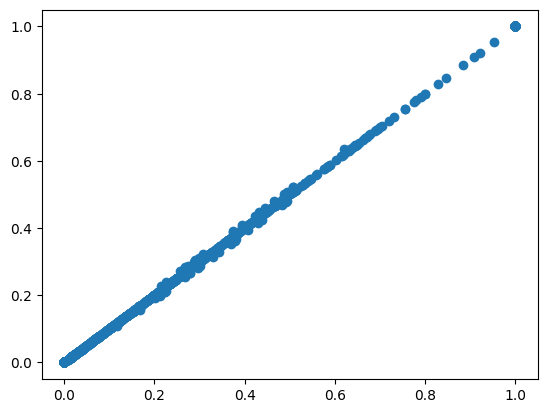

In [ ]:
# Flatten the lists
flat_measure = [item for sublist in measure for item in sublist]
flat_constraints = [item for sublist in constraints for item in sublist]

# Plot the data
plt.scatter(flat_measure, flat_constraints)
plt.show()

In [181]:
# Calculate the absolute difference
absolute_difference = np.abs(test.constraints-test.start_macro_data)

# Calculate the percentage difference
# Using the original values as the reference
random_percentage_difference = (absolute_difference / test.constraints) * 100



In [165]:
# Calculate the absolute difference
absolute_difference = np.abs(test.constraints-test.macro_data)

# Calculate the percentage difference
# Using the original values as the reference
optimised_percentage_difference = (absolute_difference / test.constraints) * 100
print(random_percentage_difference)
print(optimised_percentage_difference)
print(random_percentage_difference-optimised_percentage_difference)

[ 8.2962963  31.48269105  5.65675935  2.04666394 13.671875    7.54138565
 10.83991385 10.46249783]
[ 8.2962963  31.48269105  5.65675935  2.04666394 13.671875    7.54138565
 10.83991385 10.46249783]
[0. 0. 0. 0. 0. 0. 0. 0.]


In [12]:
# Initialize shared memory ONCE at program start
ParallelSimulatedAnnealing.initialize_shared_microdata(micro_data['data_array'])

population = []
energies = []
measure = []
constraints = []

for i in range(100):
    pop_attributes = {
        'pos': 0,
        'geo_id': constraint_data['geo_data_ids'][i],
        'population_size': float(constraint_data['population_totals'][i]),
        'constraints': constraint_data['data_array'][i],
        'weights': all_weights,
        # Note: We don't need to pass micro_data here anymore
        # It's handled by the class via the shared memory
    }
    
    sim = ParallelSimulatedAnnealing(sa_attributes, pop_attributes)
    res = sim.optimize(False)
    
    population.append(res['population'])
    energies.append(res['energy'])
    measure.append(res['macro_data'])
    constraints.append(constraint_data['data_array'][i])
    print(res['energy'])

NameError: name 'new_idx' is not defined